Team 6: Alice Friedman, Stephen Jones, Jeffrey Littlejohn, Jun Pan


REQUIREMENT: It can be useful to be able to classify new "test" documents using already classified "training" documents.  A common example is using a corpus of labeled spam and ham (non-spam) e-mails to predict whether or not a new document is spam.  Here is one example of such data:  UCI Machine Learning Repository: Spambase Data Set

For this project, you can either use the above dataset to predict the class of new documents (either withheld from the training dataset or from another source such as your own spam folder).

For more adventurous students, you are welcome (encouraged!) to come up a different set of documents (including scraped web pages!?) that have already been classified (e.g. tagged), then analyze these documents to predict how new documents should be classified.

In our study, we are goint to explore Spambase Dataset from the UCI Machine Learning Repository (http://archive.ics.uci.edu/ml/datasets/Spambase).   We try to build decision tree, random forest, and support vector machine models.  To comparing accuracy among models, confusion matrix will be built and misclassied email will be evaluated.  

In [96]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from lxml import html
import requests
import re
import nltk
import urllib3
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from nltk.tokenize import word_tokenize

In [19]:
# load the data
spambase = pd.read_csv("https://raw.githubusercontent.com/johnpannyc/data620_week5_part2_team6/master/spambase.data")

In [22]:
#visualize data
spambase.head()

,0,0.64,0.64.1,0.1,0.32,0.2,0.3,0.4,0.5,0.6,...,0.40,0.41,0.42,0.778,0.43,0.44,3.756,61,278,1
0,0.21,0.28,0.50,0.0,0.14,0.28,0.21,0.07,0.00,0.94,...,0.00,0.132,0.0,0.372,0.180,0.048,5.114,101,1028,1
1,0.06,0.00,0.71,0.0,1.23,0.19,0.19,0.12,0.64,0.25,...,0.01,0.143,0.0,0.276,0.184,0.010,9.821,485,2259,1
2,0.00,0.00,0.00,0.0,0.63,0.00,0.31,0.63,0.31,0.63,...,0.00,0.137,0.0,0.137,0.000,0.000,3.537,40,191,1
3,0.00,0.00,0.00,0.0,0.63,0.00,0.31,0.63,0.31,0.63,...,0.00,0.135,0.0,0.135,0.000,0.000,3.537,40,191,1
4,0.00,0.00,0.00,0.0,1.85,0.00,0.00,1.85,0.00,0.00,...,0.00,0.223,0.0,0.000,0.000,0.000,3.000,15,54,1


In [23]:
#add columns name
spambase.columns=['word_freq_make','word_freq_address','word_freq_all','word_freq_3d','word_freq_our','word_freq_over',
              'word_freq_remove','word_freq_internet','word_freq_order','word_freq_mail','word_freq_receive',
              'word_freq_will','word_freq_people','word_freq_report','word_freq_addresses','word_freq_free',
              'word_freq_business','word_freq_email','word_freq_you','word_freq_credit','word_freq_your',
              'word_freq_font','word_freq_000','word_freq_money','word_freq_hp','word_freq_hpl','word_freq_george',
              'word_freq_650','word_freq_lab','word_freq_labs','word_freq_telnet','word_freq_857','word_freq_data',
              'word_freq_415','word_freq_85','word_freq_technology','word_freq_1999','word_freq_parts','word_freq_pm',
              'word_freq_direct','word_freq_cs','word_freq_meeting','word_freq_original','word_freq_project',
              'word_freq_re','word_freq_edu','word_freq_table','word_freq_conference','char_freq_;','char_freq_(',
              'char_freq_[','char_freq_!','char_freq_$','char_freq_#','capital_run_length_average','capital_run_length_longest',
              'capital_run_length_total','spamclass']                       

In [24]:
spambase.head(5)

,word_freq_make,word_freq_address,word_freq_all,word_freq_3d,word_freq_our,word_freq_over,word_freq_remove,word_freq_internet,word_freq_order,word_freq_mail,...,char_freq_;,char_freq_(,char_freq_[,char_freq_!,char_freq_$,char_freq_#,capital_run_length_average,capital_run_length_longest,capital_run_length_total,spamclass
0,0.21,0.28,0.50,0.0,0.14,0.28,0.21,0.07,0.00,0.94,...,0.00,0.132,0.0,0.372,0.180,0.048,5.114,101,1028,1
1,0.06,0.00,0.71,0.0,1.23,0.19,0.19,0.12,0.64,0.25,...,0.01,0.143,0.0,0.276,0.184,0.010,9.821,485,2259,1
2,0.00,0.00,0.00,0.0,0.63,0.00,0.31,0.63,0.31,0.63,...,0.00,0.137,0.0,0.137,0.000,0.000,3.537,40,191,1
3,0.00,0.00,0.00,0.0,0.63,0.00,0.31,0.63,0.31,0.63,...,0.00,0.135,0.0,0.135,0.000,0.000,3.537,40,191,1
4,0.00,0.00,0.00,0.0,1.85,0.00,0.00,1.85,0.00,0.00,...,0.00,0.223,0.0,0.000,0.000,0.000,3.000,15,54,1


In [25]:
# Count the number of spam vs. not spam
spam_count = len(spambase[spambase.spamclass==1])
ham_count = len(spambase[spambase.spamclass==0])

print("Spam: %d" %spam_count)
print("Ham: %d" %ham_count)

Spam: 1812
Ham: 2788


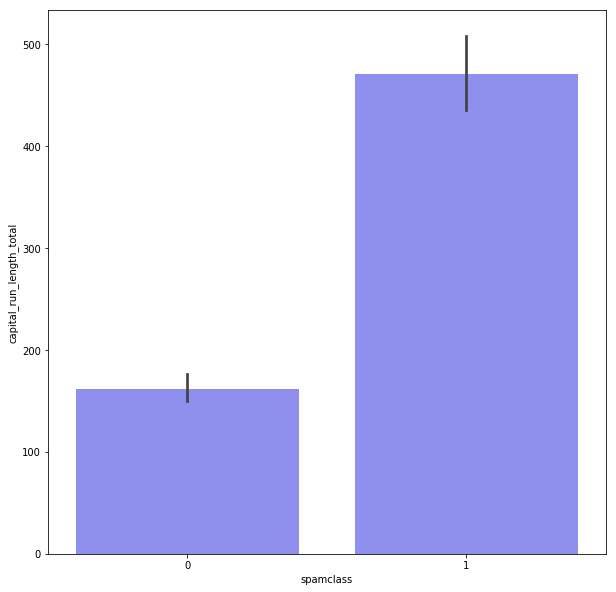

In [61]:
#Creat bar plot for Spam and Ham
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize = (10,10))
sns.barplot(x="spamclass", y="capital_run_length_total", color = 'blue', alpha = 0.5, data = spambase)

SPLIT DATASET

In [26]:
#train 70%, test 30%
X = spambase.values[:, 0:57]
y = spambase.values[:, 57]

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=.7)

C:\Users\tbao\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2069: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


In [ ]:
DECISION TREE

In [27]:
from sklearn.tree import DecisionTreeClassifier

dt = DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
    max_features=None, max_leaf_nodes=None,
    min_impurity_split=1e-07, min_samples_leaf=1,
    min_samples_split=2, min_weight_fraction_leaf=0.0,
    presort=False, random_state=88, splitter='best')
dt.fit(X_train, y_train)
dt.score(X_test, y_test)

C:\Users\tbao\Anaconda3\lib\site-packages\sklearn\tree\tree.py:282: DeprecationWarning: The min_impurity_split parameter is deprecated and will be removed in version 0.21. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)


0.9144927536231884

In [29]:
#Create confusion matrix
dt_cm = confusion_matrix(y_test, dt.predict(X_test))
pd.DataFrame(data = dt_cm, columns = ['Predicted 0', 'Predicted 1'],
            index = ['Actual 0', 'Actual 1'])

,Predicted 0,Predicted 1
Actual 0,762,63
Actual 1,55,500


In [43]:
#In summary
dt_pred = dt.predict(X_test)
print("Number of mislabeled emails out of a total %d emails in test dataset : %d"
       % (X_test.shape[0],(y_test != dt_pred).sum()))
print("In detail, %d ham emails are mislabeled as spam, %d spam emails are mislabeled as ham."
      % (dt_cm [0,1], dt_cm[1,0]))

Number of mislabeled emails out of a total 1380 emails in test dataset : 118
In detail, 63 ham emails are mislabeled as spam, 55 spam emails are mislabeled as ham.


Feature Importance
Generally, importance provides a score that indicates how useful or valuable each feature was in the construction of the boosted decision trees within the model. The more an attribute is used to make key decisions with decision trees, the higher its relative importance.

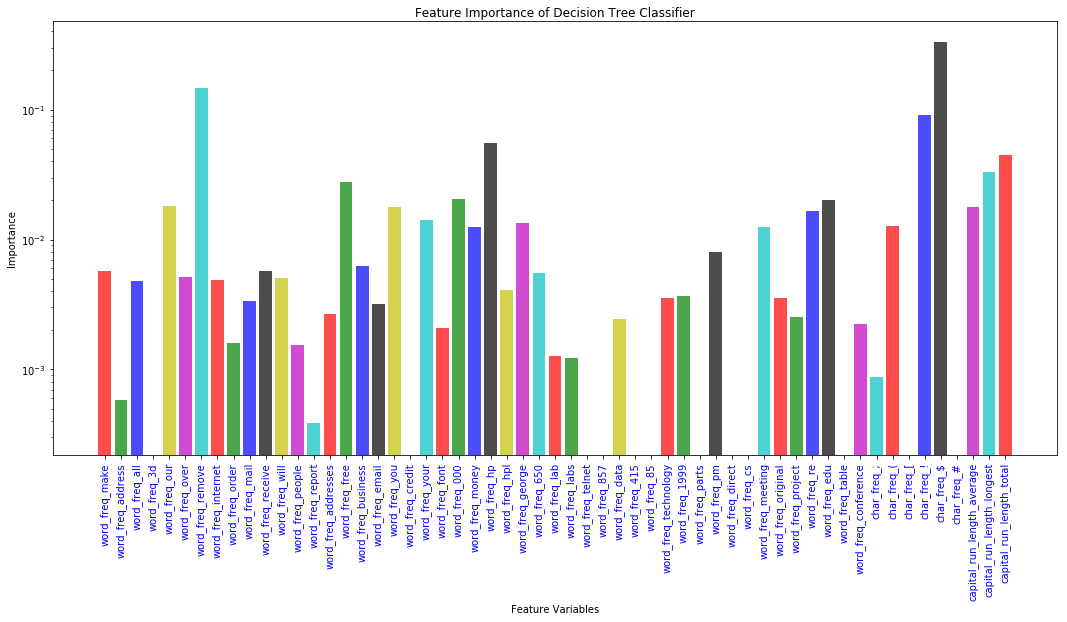

In [69]:
## Reference:https://datawhatnow.com/feature-importance/
feature_importance = dt.feature_importances_
plt.figure(figsize=(18, 8))
plt.yscale('log', nonposy='clip')
plt.bar(range(len(feature_importance)), feature_importance, align='center', color = 'rgbkymc', alpha = 0.7)
plt.xticks(range(len(feature_importance)), spambase.columns, rotation='vertical', color = 'blue')
plt.title('Feature Importance of Decision Tree Classifier')
plt.ylabel('Importance')
plt.xlabel('Feature Variables')
plt.show()

RANDOM FOREST

We assume that the user knows about the construction of single classification trees. Random Forests grows many classification trees. To classify a new object from an input vector, put the input vector down each of the trees in the forest. Each tree gives a classification, and we say the tree "votes" for that class. The forest chooses the classification having the most votes (over all the trees in the forest).

Random forests does not overfit. You can run as many trees as you want. It is fast. 

In [63]:
#Build model and get accuracy
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=1, oob_score=False, random_state=88,
            verbose=0, warm_start=False)
rf.fit(X_train, y_train)
rf.score(X_test, y_test)

C:\Users\tbao\Anaconda3\lib\site-packages\sklearn\tree\tree.py:282: DeprecationWarning: The min_impurity_split parameter is deprecated and will be removed in version 0.21. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
C:\Users\tbao\Anaconda3\lib\site-packages\sklearn\tree\tree.py:282: DeprecationWarning: The min_impurity_split parameter is deprecated and will be removed in version 0.21. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
C:\Users\tbao\Anaconda3\lib\site-packages\sklearn\tree\tree.py:282: DeprecationWarning: The min_impurity_split parameter is deprecated and will be removed in version 0.21. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
C:\Users\tbao\Anaconda3\lib\site-packages\sklearn\tree\tree.py:282: DeprecationWarning: The min_impurity_split parameter is deprecated and will be removed in version 0.21. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
C:\Users\tbao\Anaconda3\lib\

0.9572463768115942

In [65]:
#Create confusion matrix
rf_cm = confusion_matrix(y_test, rf.predict(X_test))
pd.DataFrame(data = rf_cm, columns = ['Predicted 0', 'Predicted 1'],
            index = ['Actual 0', 'Actual 1'])

,Predicted 0,Predicted 1
Actual 0,804,21
Actual 1,38,517


In [67]:
#In summary
rf_pred = rf.predict(X_test)
print("Number of mislabeled emails out of a total %d emails in test dataset : %d"
       % (X_test.shape[0],(y_test != rf_pred).sum()))
print("In detail, %d ham emails are mislabeled as spam, %d spam emails are mislabeled as ham."
      % (rf_cm [0,1], rf_cm[1,0]))

Number of mislabeled emails out of a total 1380 emails in test dataset : 59
In detail, 21 ham emails are mislabeled as spam, 38 spam emails are mislabeled as ham.


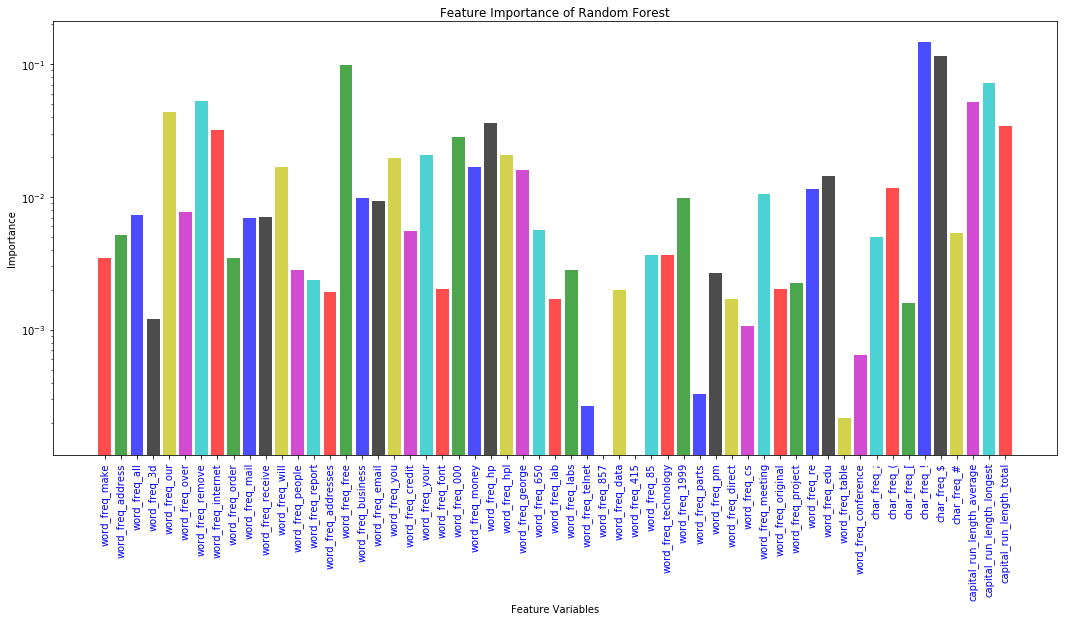

In [70]:
feature_importance = rf.feature_importances_
plt.figure(figsize=(18, 8))
plt.yscale('log', nonposy='clip')
plt.bar(range(len(feature_importance)), feature_importance, align='center', color = 'rgbkymc', alpha = 0.7)
plt.xticks(range(len(feature_importance)), spambase.columns, rotation='vertical', color = 'blue')
plt.title('Feature Importance of Random Forest')
plt.ylabel('Importance')
plt.xlabel('Feature Variables')
plt.show()

ADAPTIVE BOOSTING

It focuses on classification problems and aims to convert a set of weak classifiers into a strong one. 

In [72]:
from sklearn.ensemble import AdaBoostClassifier
ada = AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=1.0, n_estimators=50, random_state=88)
ada.fit(X_train, y_train)
ada.score(X_test, y_test)

0.9456521739130435

In [73]:
ada_cm = confusion_matrix(y_test, ada.predict(X_test))

pd.DataFrame(data = ada_cm, columns = ['Predicted 0', 'Predicted 1'],
            index = ['Actual 0', 'Actual 1'])

,Predicted 0,Predicted 1
Actual 0,787,38
Actual 1,37,518


In [74]:
#In summary
ada_pred = ada.predict(X_test)
print("Number of mislabeled emails out of a total %d emails in test dataset : %d"
       % (X_test.shape[0],(y_test != ada_pred).sum()))
print("In detail, %d ham emails are mislabeled as spam, %d spam emails are mislabeled as ham."
      % (ada_cm [0,1], ada_cm[1,0]))

Number of mislabeled emails out of a total 1380 emails in test dataset : 75
In detail, 38 ham emails are mislabeled as spam, 37 spam emails are mislabeled as ham.


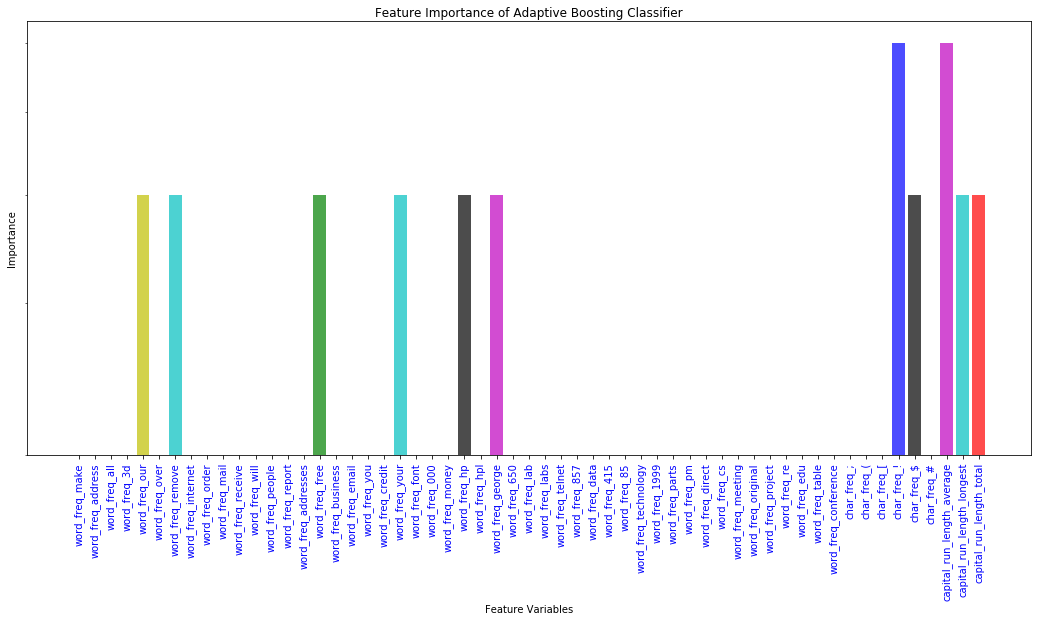

In [75]:
feature_importance = ada.feature_importances_
plt.figure(figsize=(18, 8))
plt.yscale('log', nonposy='clip')
plt.bar(range(len(feature_importance)), feature_importance, align='center', color = 'rgbkymc', alpha = 0.7)
plt.xticks(range(len(feature_importance)), spambase.columns, rotation='vertical', color = 'blue')
plt.title('Feature Importance of Adaptive Boosting Classifier')
plt.ylabel('Importance')
plt.xlabel('Feature Variables')
plt.show()

In [ ]:
SUPPORT VECTOR MACHINE

A Support Vector Machine (SVM) is a discriminative classifier formally defined by a separating hyperplane. In other words, given labeled training data (supervised learning), the algorithm outputs an optimal hyperplane which categorizes new examples. In two dimentional space this hyperplane is a line dividing a plane in two parts where in each class lay in either side.

In [76]:
from sklearn.svm import SVC
svm = SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=88, shrinking=True,
  tol=0.001, verbose=False)
svm.fit(X_train, y_train)
svm.score(X_test, y_test)

0.8340579710144927

In [77]:
svm_cm = confusion_matrix(y_test, svm.predict(X_test))

pd.DataFrame(data = svm_cm, columns = ['Predicted 0', 'Predicted 1'],
            index = ['Actual 0', 'Actual 1'])

,Predicted 0,Predicted 1
Actual 0,700,125
Actual 1,104,451


In [78]:
#In summary
svm_pred = svm.predict(X_test)
print("Number of mislabeled emails out of a total %d emails in test dataset : %d"
       % (X_test.shape[0],(y_test != svm_pred).sum()))
print("In detail, %d ham emails are mislabeled as spam, %d spam emails are mislabeled as ham."
      % (svm_cm [0,1], svm_cm[1,0]))

Number of mislabeled emails out of a total 1380 emails in test dataset : 229
In detail, 125 ham emails are mislabeled as spam, 104 spam emails are mislabeled as ham.


K NEIGBORS CLASSIFIER
K Nearest Neighbor(KNN) is a very simple, easy to understand, versatile and one of the topmost machine learning algorithms. KNN used in the variety of applications such as finance, healthcare, political science, handwriting detection, image recognition and video recognition. In Credit ratings, financial institutes will predict the credit rating of customers. In loan disbursement, banking institutes will predict whether the loan is safe or risky. In political science, classifying potential voters in two classes will vote or won’t vote. KNN algorithm used for both classification and regression problems. KNN algorithm based on feature similarity approach.

In [91]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors=9, weights= 'uniform', algorithm = 'auto', n_jobs = -1, leaf_size = 30, 
                           p = 2, metric = 'minkowski', metric_params = None)
knn.fit(X_train, y_train)
knn.score(X_test, y_test)

0.8

In [92]:
knn_cm = confusion_matrix(y_test, knn.predict(X_test))

pd.DataFrame(data = knn_cm, columns = ['Predicted 0', 'Predicted 1'],
            index = ['Actual 0', 'Actual 1'])

,Predicted 0,Predicted 1
Actual 0,696,129
Actual 1,147,408


In [93]:
#In summary
knn_pred = knn.predict(X_test)
print("Number of mislabeled emails out of a total %d emails in test dataset : %d"
       % (X_test.shape[0],(y_test != knn_pred).sum()))
print("In detail, %d ham emails are mislabeled as spam, %d spam emails are mislabeled as ham."
      % (knn_cm [0,1], knn_cm[1,0]))

Number of mislabeled emails out of a total 1380 emails in test dataset : 276
In detail, 129 ham emails are mislabeled as spam, 147 spam emails are mislabeled as ham.


CONCLUSION

In [99]:
#reference:https://datawhatnow.com/feature-importance/
Conclusion = {'Decision Tree' : [dt.score(X_test, y_test), (y_test != dt_pred).sum()],
             'Random Forest' : [rf.score(X_test, y_test), (y_test != rf_pred).sum()],
             'AdaBoost' : [ada.score(X_test, y_test), (y_test != ada_pred).sum()],
             'SVM' : [svm.score(X_test, y_test), (y_test != svm_pred).sum()],
             'KNN' : [knn.score(X_test, y_test), (y_test != svm_pred).sum()]}
pd.DataFrame (Conclusion)
pd.DataFrame(Conclusion, index=['Acuracy', 'Mislabel'])

,AdaBoost,Decision Tree,KNN,Random Forest,SVM
Acuracy,0.945652,0.914493,0.8,0.957246,0.834058
Mislabel,75.000000,118.000000,229.0,59.000000,229.000000


In conclusion, according to the aruracy rate and number of mislabeled emails, Random Forest (0.96), Adaptive Boosting (0.95) and Decsion Tree (0.91) are ranked top three for high accuracy and less mislabelled email.  